In [54]:
import pandas as pd

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [55]:
dataset = 'model/gesture_classifier/gesture_face.csv'
model_save_path = 'model/gesture_classifier/gesture_classifier.hdf5'

In [56]:
df = pd.read_csv(dataset, header=None)
df.columns = ['label'] + [f'feat_{i}' for i in range(len(df.columns)-1)]
df = df.astype(np.float32)
df['label'] = df['label'].astype(np.int32)
df

,label,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_694,feat_695,feat_696,feat_697,feat_698,feat_699,feat_700,feat_701,feat_702,feat_703
0,0,0.0,0.0,0.004688,-0.129167,0.012500,-0.252083,-0.001563,0.050000,0.000000,...,-0.006250,0.116667,-0.107813,-0.177083,0.006250,-0.154167,0.131250,-0.122917,0.129688,-0.158333
1,0,0.0,0.0,0.009375,-0.133333,0.015625,-0.256250,0.000000,0.047917,0.003125,...,0.017188,0.068750,-0.146875,-0.358333,0.020312,-0.341667,0.210938,-0.295833,0.206250,-0.350000
2,0,0.0,0.0,0.003125,-0.150000,0.010937,-0.291667,-0.001563,0.050000,-0.001563,...,0.071875,0.127083,-0.096875,-0.306250,0.076563,-0.285417,0.260938,-0.241667,0.257812,-0.295833
3,0,0.0,0.0,0.001563,-0.195833,0.007812,-0.381250,0.000000,0.072917,-0.003125,...,0.151562,0.204167,-0.009375,-0.227083,0.162500,-0.202083,0.339063,-0.158333,0.335938,-0.210417
4,0,0.0,0.0,0.004688,-0.197917,0.009375,-0.385417,0.000000,0.079167,0.001563,...,0.142188,0.164583,-0.021875,-0.272917,0.154687,-0.250000,0.329688,-0.202083,0.326562,-0.256250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,0,0.0,0.0,0.004688,-0.110417,0.007812,-0.214583,0.000000,0.041667,0.003125,...,-0.012500,0.116667,-0.112500,-0.127083,-0.010937,-0.118750,0.092188,-0.095833,0.089062,-0.127083
593,0,0.0,0.0,0.003125,-0.108333,0.006250,-0.210417,0.000000,0.039583,0.001563,...,-0.010937,0.122917,-0.104687,-0.125000,-0.003125,-0.110417,0.098438,-0.085417,0.096875,-0.114583
594,0,0.0,0.0,0.006250,-0.110417,0.010937,-0.212500,0.000000,0.041667,0.001563,...,-0.009375,0.116667,-0.096875,-0.129167,-0.001563,-0.118750,0.104687,-0.089583,0.103125,-0.118750
595,0,0.0,0.0,0.009375,-0.112500,0.018750,-0.214583,-0.001563,0.041667,0.003125,...,-0.001563,0.120833,-0.084375,-0.137500,0.015625,-0.116667,0.120312,-0.081250,0.118750,-0.112500


In [57]:
#label 0 and 3 has the same label in the dataset
def realign(x):
    if x == 3:
        return 0
    elif x == 4:
        return 3
    return x
df['label'] = df['label'].apply(lambda x: realign(x))

In [58]:
print('Label distribution (count): ', df['label'].value_counts())

Label distribution (count):  label
0    298
2    101
1     99
3     99
Name: count, dtype: int64


In [59]:
print('Label distribution (%): ', df['label'].value_counts()/df.shape[0] * 100)

Label distribution (%):  label
0    49.916248
2    16.917923
1    16.582915
3    16.582915
Name: count, dtype: float64


In [60]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='label'), df['label'], train_size=2/3, random_state=RANDOM_SEED, stratify=df['label'])

In [61]:
TIME_STEPS = 32
DIMENSION = 2 * 11
NUM_CLASSES = len(df['label'].unique())

In [62]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION,)),
    tf.keras.layers.Reshape((TIME_STEPS, DIMENSION)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dense(8192, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(.05),
        # tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [63]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 32, 22)            0         
                                                                 
 lstm_6 (LSTM)               (None, 32, 32)            7040      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               4224      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_7 (Dropout)         (None, 128)              

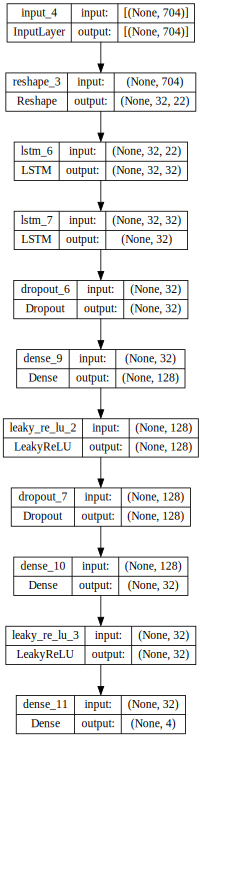

In [64]:
from IPython.display import SVG
from keras.utils import model_to_dot

iv1_dot = model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60)
SVG(iv1_dot.create(prog=['dot'], format='svg'))

In [65]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [66]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [67]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
12/13 [==========================>...] - ETA: 0s - loss: 1.3611 - accuracy: 0.4349
Epoch 1: saving model to model/gesture_classifier\gesture_classifier.hdf5
13/13 [==============================] - 7s 138ms/step - loss: 1.3587 - accuracy: 0.4372 - val_loss: 1.3078 - val_accuracy: 0.4975
Epoch 2/1000
 5/13 [==========>...................] - ETA: 0s - loss: 1.3089 - accuracy: 0.4750

c:\Users\Prometheus\.conda\envs\cv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - ETA: 0s - loss: 1.2532 - accuracy: 0.5000
Epoch 2: saving model to model/gesture_classifier\gesture_classifier.hdf5
13/13 [==============================] - 1s 40ms/step - loss: 1.2532 - accuracy: 0.5000 - val_loss: 1.2565 - val_accuracy: 0.4975
Epoch 3/1000
13/13 [==============================] - ETA: 0s - loss: 1.2435 - accuracy: 0.5000
Epoch 3: saving model to model/gesture_classifier\gesture_classifier.hdf5
13/13 [==============================] - 0s 34ms/step - loss: 1.2435 - accuracy: 0.5000 - val_loss: 1.2381 - val_accuracy: 0.4975
Epoch 4/1000
12/13 [==========================>...] - ETA: 0s - loss: 1.2475 - accuracy: 0.4948
Epoch 4: saving model to model/gesture_classifier\gesture_classifier.hdf5
13/13 [==============================] - 0s 37ms/step - loss: 1.2432 - accuracy: 0.5000 - val_loss: 1.2226 - val_accuracy: 0.4975
Epoch 5/1000
11/13 [========================>.....] - ETA: 0s - loss: 1.2059 - accuracy: 0.5057
Epoch 5: saving m

In [68]:
model = tf.keras.models.load_model(model_save_path)

In [69]:
predict_result = model.predict(np.array([X_test.iloc[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 1s 1s/step
[7.5422015e-09 2.8709812e-07 9.9998987e-01 9.8791406e-06]
2


7/7 [==============================] - 0s 10ms/step


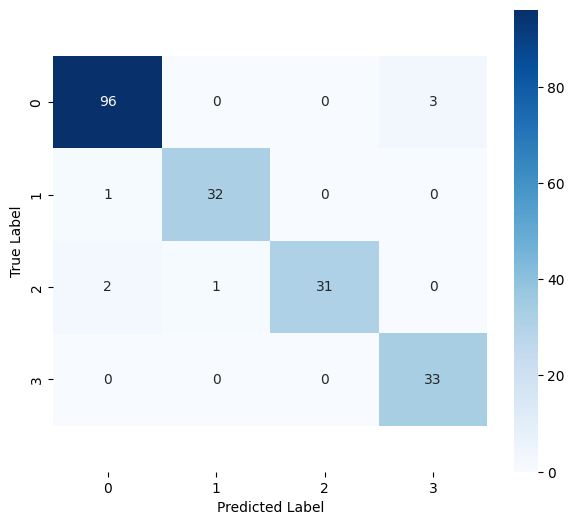

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        99
           1       0.97      0.97      0.97        33
           2       1.00      0.91      0.95        34
           3       0.92      1.00      0.96        33

    accuracy                           0.96       199
   macro avg       0.96      0.96      0.96       199
weighted avg       0.97      0.96      0.96       199



In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False, cmap="Blues")
    
    # Set axis labels
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    # Adjust y-axis limits to ensure correct display
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

# Example usage with your model and test data
# Assuming you have already trained your model and have X_test and y_test
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)


In [71]:
model.save(model_save_path, include_optimizer=False)

c:\Users\Prometheus\.conda\envs\cv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
